In [21]:
"""Example showing the optimization and evolution of surrogates"""

# Copyright (c) 2025 Alliance for Energy Innovation, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__deprecated__ = False

# Optimization routines and surrogate updates

This example shows how to run the optimization routines in `soogo` and visualize the updated surrogate model. We use two-dimensional problems to be able to visualize the progress.

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def plot_2d(x, y, FX, bounds, label):
    fig, ax = plt.subplots()
    im = ax.imshow(
        FX,
        cmap="jet",
        extent=[bounds[0][0], bounds[0][1], bounds[1][1], bounds[1][0]],
    )
    fig.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.scatter(x[0 : len(x) - 1], y[0 : len(x) - 1], c="gray", marker="x")
    ax.scatter(x[-1], y[-1], c="w", marker="x")
    return fig, ax

The optimization uses one of the three objective functions:

1. `ackley()`: Many local minima, single global minimum. Global minimum is significantly smaller than local minima relative to the output range.
2. `eggholder()`: Many local minima, single global minimum. Global minimum and local minima are similar relative to the output range.
3. `quadratic()`: Convex problem, i.e., single minimum point. The objective function graph is almost flat.

The global minimum in the Ackley function is achieved in the origin (0,0) in the center of the domain. Some methods start sampling at the center of the domain. Thus, to make a fair comparison, we shift the minimum so no method have this initial advantage.

In [23]:
def ackley(x, n: int = 2):
    from math import exp, sqrt, pi

    a = 20
    b = 0.2
    c = 2 * pi
    return (
        -a * exp(-b * sqrt(np.dot(x, x) / n))
        - exp(np.sum(np.cos(c * np.asarray(x))) / n)
        + a
        + exp(1)
    )


def eggholder(x):
    return -(x[1] + 47) * np.sin(np.sqrt(abs(x[1] + 0.5 * x[0] + 47))) - x[
        0
    ] * np.sin(np.sqrt(abs(x[0] - (x[1] + 47))))


def quadratic(x):
    return (x[0] - 500) ** 2 + (x[1] - 2875) ** 2


objf = {}
# Breaks the symmetry of the problem
objf["ackley"] = lambda x: ackley([xi - 3.14 for xi in x], n=2)
objf["eggholder"] = eggholder
objf["quadratic"] = quadratic

refbounds = {}
refbounds["ackley"] = [-32.768, 32.768]
refbounds["eggholder"] = [-512, 512]
refbounds["quadratic"] = [0, 10000]

Choose the objective function by changing the variable below:

In [24]:
# Define problem, dimensions and bounds
n = 2
funcstr = "ackley"


def func(x):
    return [objf[funcstr](xi) for xi in x]


bounds = [refbounds[funcstr]] * n

We define below the grid used for plotting the surrogate model at each step.

In [25]:
# Grid for plotting
nx = 100
ny = 100
x = np.linspace(bounds[0][0], bounds[0][1], nx)
y = np.linspace(bounds[1][0], bounds[1][1], ny)
XY = np.array([[[x[j], y[i]] for j in range(nx)] for i in range(ny)])

To better visualize the intermediate steps of each optimizer, we define callback functions, which are called after each optimization step.

In [26]:
import soogo
from soogo import GaussianProcess, RbfModel, MedianLpfFilter, OptimizeResult
from soogo.utils import gp_expected_improvement


def callback_rbf(res: OptimizeResult, T: int = 10, savefig: bool = False):
    """
    Callback for an optimizer that uses the RBF surrogate.

    :param soogo.OptimizeResult res: Optimization current status.
    :param int T: The period for plotting results. Plot figures from T to T
        steps.
    :param bool savefig: Inform if figures should be saved to file.
        Default: False.
    """

    print("Best value of ", res.fx, " at ", res.x)
    print("Last sample point at ", res.sample[res.nfev - 1])

    if (res.nfev % T == 0 and res.nfev >= T) or savefig:
        # Train model
        model = RbfModel()
        model.reserve(0, n)
        model.update(res.sample[0 : res.nfev, :], res.fsample[0 : res.nfev])

        # Evaluate points in the grid
        S = np.zeros((ny, nx))
        for i in range(ny):
            S[i, :] = model(XY[i, :])

        # Plot figure
        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            S,
            bounds,
            "s(x,y)",
        )
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()


def callback_cptv(res: OptimizeResult, savefig: bool = False):
    """
    Callback for the CPTV optimizer.

    Use period for plotting equals to 1 to plot every time the method exits a
    CP or TV step.
    """
    callback_rbf(res, 1, savefig)


def callback_rbf_muMeas(
    res: OptimizeResult, T: int = 10, savefig: bool = False
):
    """
    Callback for an optimizer that uses the RBF surrogate and show the mu
    measurement.

    :param soogo.OptimizeResult res: Optimization current status.
    :param int T: The period for plotting results. Plot figures from T to T
        steps.
    :param bool savefig: Inform if figures should be saved to file.
        Default: False.
    """
    callback_rbf(res, T, savefig)

    if (res.nfev % T == 0 and res.nfev >= T) or savefig:
        model = RbfModel(filter=MedianLpfFilter())
        model.reserve(0, n)
        model.update(res.sample[0 : res.nfev, :], res.fsample[0 : res.nfev])

        model.prepare_mu_measure()
        MuMeas = np.zeros((ny, nx))
        for i in range(ny):
            MuMeas[i, :] = model.mu_measure(XY[i, :])

        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            np.log(MuMeas),
            bounds,
            "log(muMeas(x,y))",
        )
        if savefig:
            plt.savefig("logMuMeas_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()


def callback_gp(res: OptimizeResult, T: int = 10, savefig: bool = False):
    """
    Callback for an optimizer that uses the GP surrogate.

    :param soogo.OptimizeResult res: Optimization current status.
    :param int T: The period for plotting results. Plot figures from T to T
        steps.
    :param bool savefig: Inform if figures should be saved to file.
        Default: False.
    """

    print("Best value of ", res.fx, " at ", res.x)
    print("Last sample point at ", res.sample[res.nfev - 1])

    if (res.nfev % T == 0 and res.nfev >= T) or savefig:
        model = GaussianProcess(n_restarts_optimizer=20, normalize_y=True)
        model.update(res.sample[0 : res.nfev, :], res.fsample[0 : res.nfev])

        Mean = np.zeros((ny, nx))
        Std = np.zeros((ny, nx))
        EI = np.zeros((ny, nx))
        for i in range(ny):
            Mean[i, :], Std[i, :] = model(XY[i, :], return_std=True)
            EI[i, :] = gp_expected_improvement(res.fx - Mean[i, :], Std[i, :])

        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            Mean,
            bounds,
            "s(x,y)",
        )
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            Std,
            bounds,
            "std(x,y)",
        )
        if savefig:
            plt.savefig("std_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(
            res.sample[0 : res.nfev, 0],
            res.sample[0 : res.nfev, 1],
            EI,
            bounds,
            "EI(x,y)",
        )
        if savefig:
            plt.savefig("EI_{:03d}.png".format(res.nfev))
        if res.nfev % T == 0:
            plt.show()
        else:
            plt.close()

Choose an optimizer and the corresponding callback function. Examples given in comments below:

Best value of  20.163528639145568  at  [19.74432335  5.3845712 ]
Last sample point at  [19.74432335  5.3845712 ]
Best value of  20.163528639145568  at  [19.74432335  5.3845712 ]
Last sample point at  [19.61873101  4.50399813]
Best value of  18.967741639327183  at  [20.28450411  9.17197216]
Last sample point at  [20.28450411  9.17197216]
Best value of  18.967741639327183  at  [20.28450411  9.17197216]
Last sample point at  [20.86333804 13.23038503]
Best value of  18.967741639327183  at  [20.28450411  9.17197216]
Last sample point at  [17.945092   9.7956848]
Best value of  18.967741639327183  at  [20.28450411  9.17197216]
Last sample point at  [22.39644618  9.08049824]
Best value of  18.967741639327183  at  [20.28450411  9.17197216]
Last sample point at  [19.82501172  8.44029491]
Best value of  15.554651836611244  at  [ 7.97581322 -3.47330961]
Last sample point at  [ 7.97581322 -3.47330961]
Best value of  15.554651836611244  at  [ 7.97581322 -3.47330961]
Last sample point at  [ 8.5826857

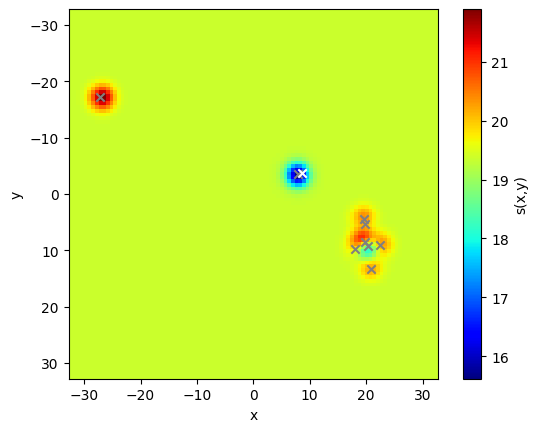

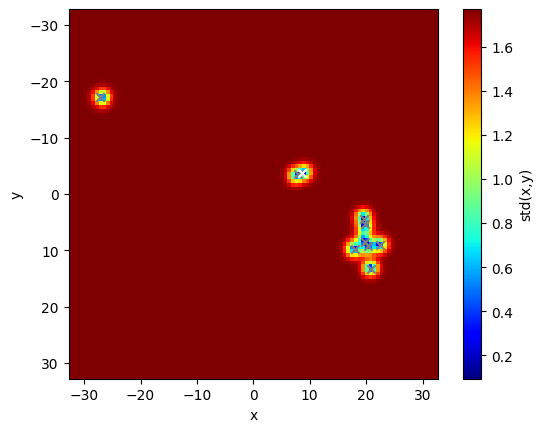

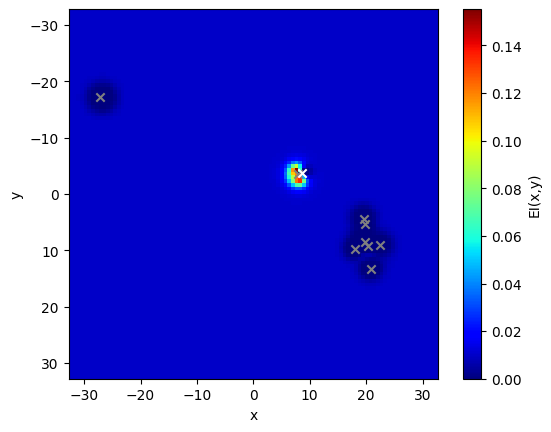

Best value of  13.82887477737776  at  [ 8.03504498 -2.73325847]
Last sample point at  [ 8.03504498 -2.73325847]
Best value of  13.506204606453508  at  [ 8.16855114 -2.04253293]
Last sample point at  [ 8.16855114 -2.04253293]
Best value of  13.487315174757958  at  [ 7.36329208 -2.01551693]
Last sample point at  [ 7.36329208 -2.01551693]
Best value of  13.487315174757958  at  [ 7.36329208 -2.01551693]
Last sample point at  [ 7.76977988 -2.15296097]
Best value of  13.487315174757958  at  [ 7.36329208 -2.01551693]
Last sample point at  [ 8.55912825 -2.33892727]
Best value of  13.487315174757958  at  [ 7.36329208 -2.01551693]
Last sample point at  [-8.04985207 11.51727024]
Best value of  13.487315174757958  at  [ 7.36329208 -2.01551693]
Last sample point at  [ 4.70875797 26.18438193]
Best value of  13.487315174757958  at  [ 7.36329208 -2.01551693]
Last sample point at  [ 8.0132037  -3.45978775]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 7.186101

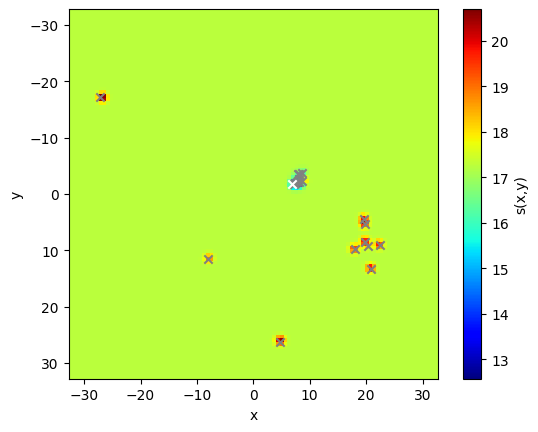

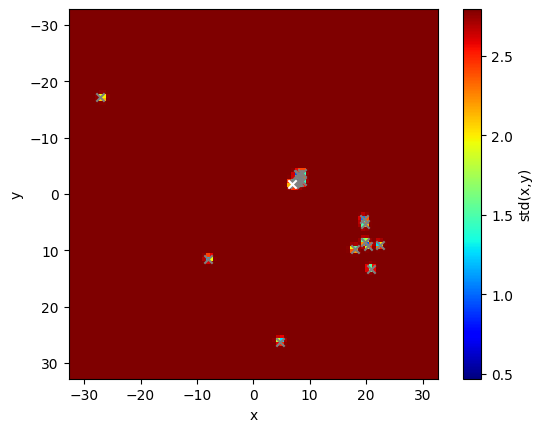

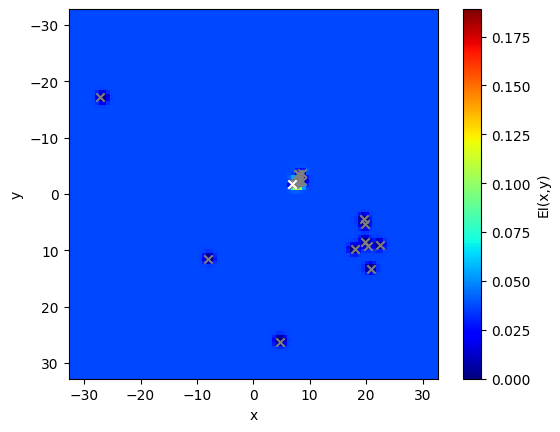

Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 7.06677137 -1.44347197]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 7.95163995 -1.54401986]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 8.6347007  -1.48823602]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 6.65685771 -3.09546877]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 5.90232506 -3.48420497]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 6.47498601 -3.99039885]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 5.58832265 -4.21653618]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 5.8796196  -2.53134514]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 5.16326

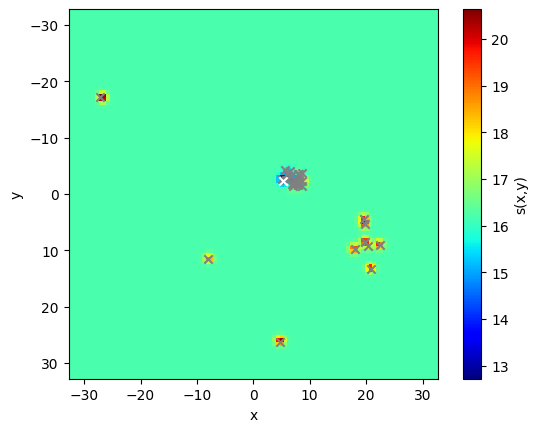

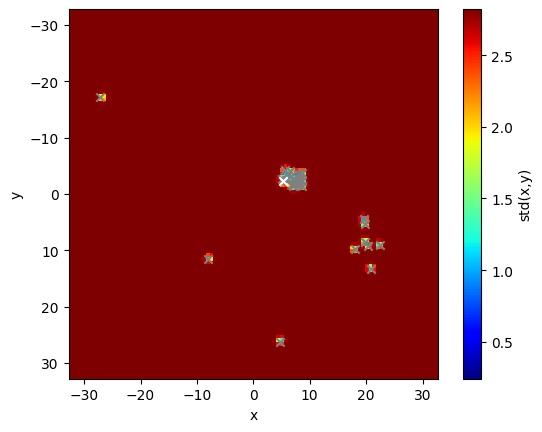

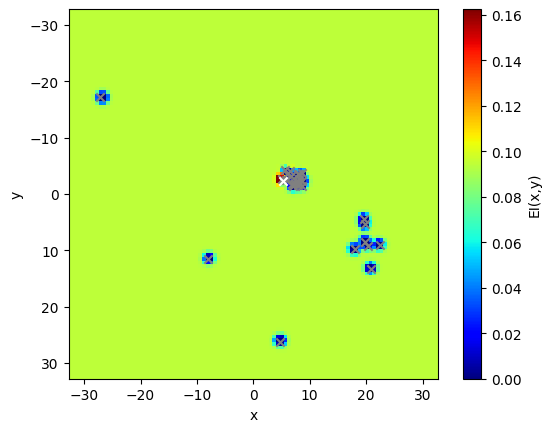

Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 4.67792179 -2.88018025]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 5.10152504 -3.36207191]
Best value of  12.140132255621339  at  [ 7.18610105 -1.76461627]
Last sample point at  [ 4.62705642 -2.20985923]
Best value of  11.380307666118554  at  [ 4.18603137 -1.41034053]
Last sample point at  [ 4.18603137 -1.41034053]
Best value of  11.380307666118554  at  [ 4.18603137 -1.41034053]
Last sample point at  [ 4.55818311 -1.3039422 ]
Best value of  9.642938573987628  at  [ 4.0520268  -1.00166016]
Last sample point at  [ 4.0520268  -1.00166016]
Best value of  9.642938573987628  at  [ 4.0520268  -1.00166016]
Last sample point at  [ 3.56470837 -0.9147038 ]
Best value of  9.642938573987628  at  [ 4.0520268  -1.00166016]
Last sample point at  [ 3.95624679 -0.63080007]
Best value of  9.642938573987628  at  [ 4.0520268  -1.00166016]
Last sample point at  [ 3.84337321 

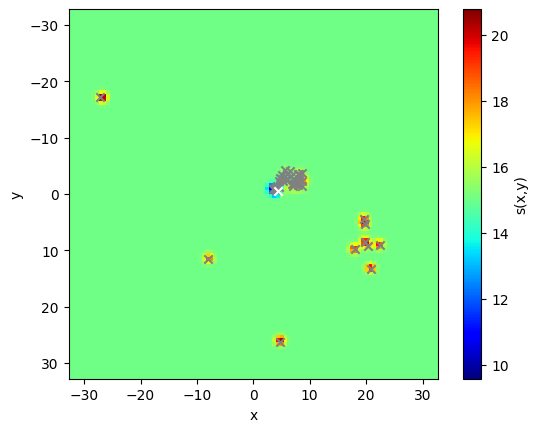

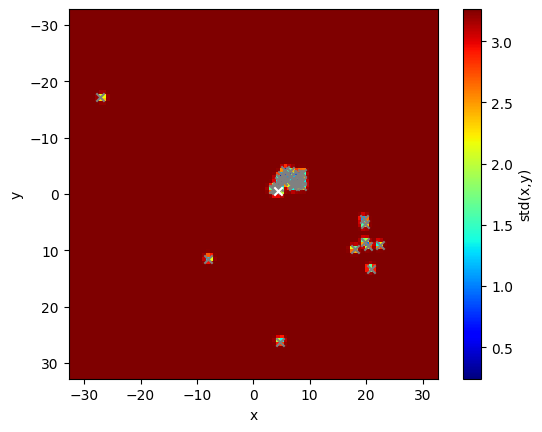

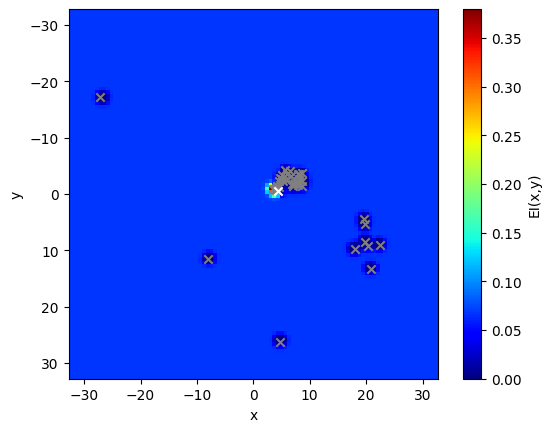

Best value of  9.642938573987628  at  [ 4.0520268  -1.00166016]
Last sample point at  [ 2.77054862 -0.88253114]
Best value of  9.642938573987628  at  [ 4.0520268  -1.00166016]
Last sample point at  [ 2.98248095 -1.18964233]
Best value of  9.642938573987628  at  [ 4.0520268  -1.00166016]
Last sample point at  [ 3.3572813  -0.35856679]
Best value of  9.330681675607234  at  [ 2.99368998 -0.70084474]
Last sample point at  [ 2.99368998 -0.70084474]
Best value of  9.330681675607234  at  [ 2.99368998 -0.70084474]
Last sample point at  [ 2.84342158 -0.22670313]
Best value of  8.255722475325289  at  [3.39556836 0.45699832]
Last sample point at  [3.39556836 0.45699832]
Best value of  8.255722475325289  at  [3.39556836 0.45699832]
Last sample point at  [3.747647   0.52146877]
Best value of  6.180109020144606  at  [3.33079642 1.02177711]
Last sample point at  [3.33079642 1.02177711]
Best value of  6.180109020144606  at  [3.33079642 1.02177711]
Last sample point at  [3.67033824 1.39224786]
Best val

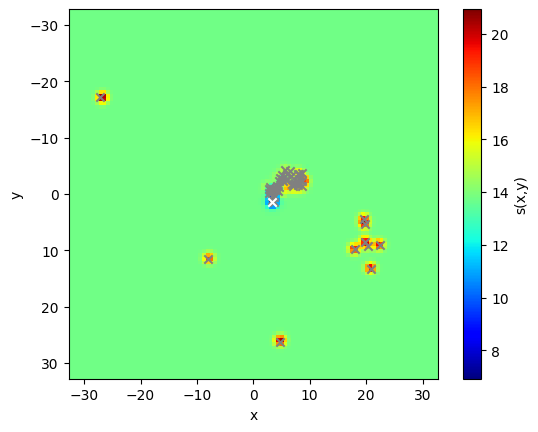

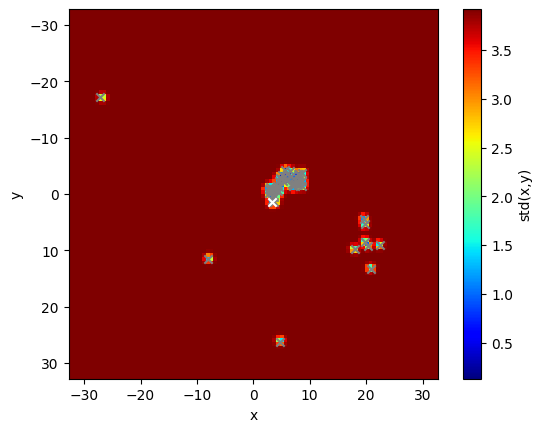

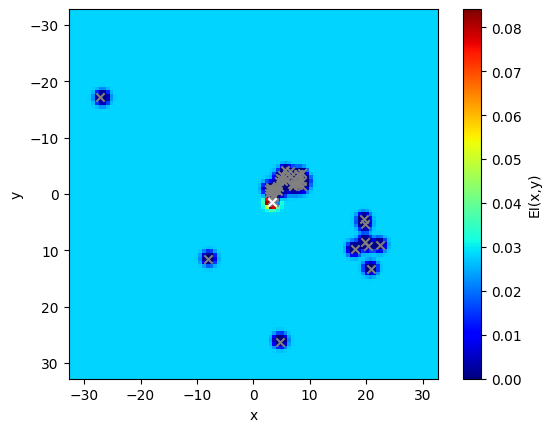

Best value of  5.6406885266138005  at  [3.25147472 1.38809996]
Last sample point at  [2.84418624 1.15929824]
Best value of  5.6406885266138005  at  [3.25147472 1.38809996]
Last sample point at  [2.79634592 1.64084221]
Best value of  2.884232392165466  at  [3.22258755 2.1181853 ]
Last sample point at  [3.22258755 2.1181853 ]
Best value of  2.884232392165466  at  [3.22258755 2.1181853 ]
Last sample point at  [3.34607403 2.44943014]
Best value of  2.884232392165466  at  [3.22258755 2.1181853 ]
Last sample point at  [3.01345753 2.44045951]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [3.17399574 2.16073772]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [4.85144522 1.37446116]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [5.45007436 2.12432424]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [6.00037328 1.46881034]
Best value of  2.630069435

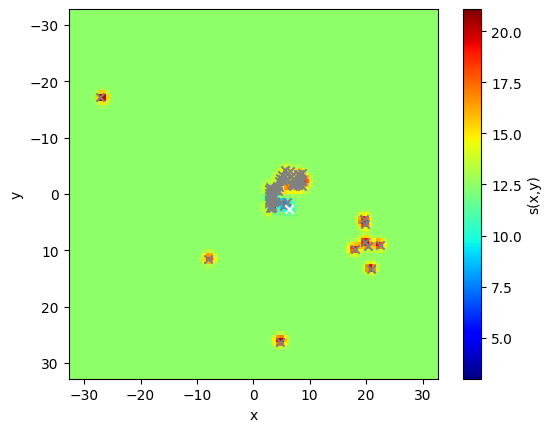

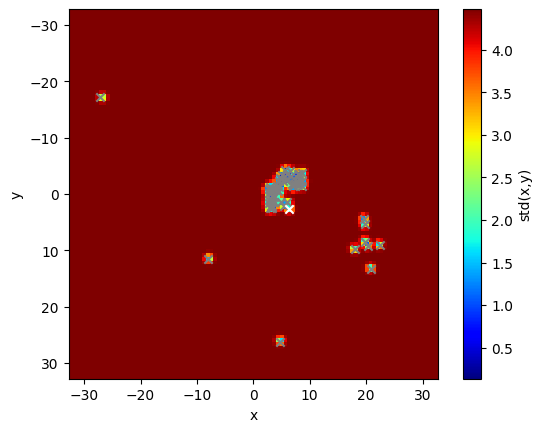

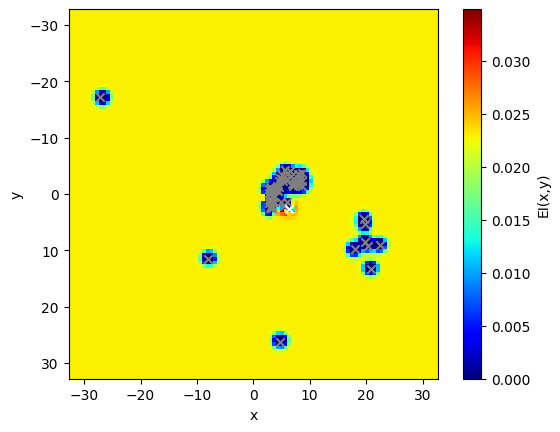

Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [5.22483452 3.11176384]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [4.61838567 2.92126288]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [4.36491997 3.73663699]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [5.00810521 3.83645456]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [4.29446708 4.64774522]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [3.4715739  4.47389578]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [3.53758057 5.37425759]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [2.67784279 4.89751454]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [2.53327231 5.8038188 ]
Best value of  2.63006943561

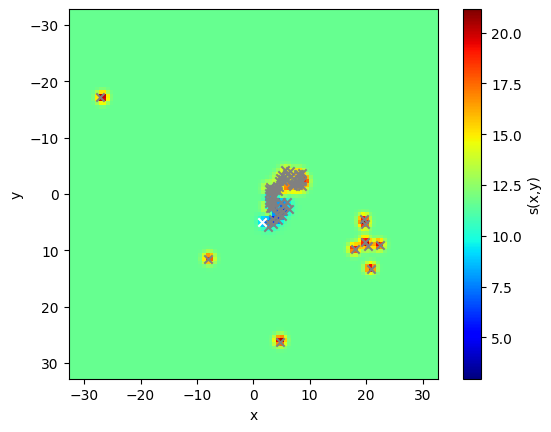

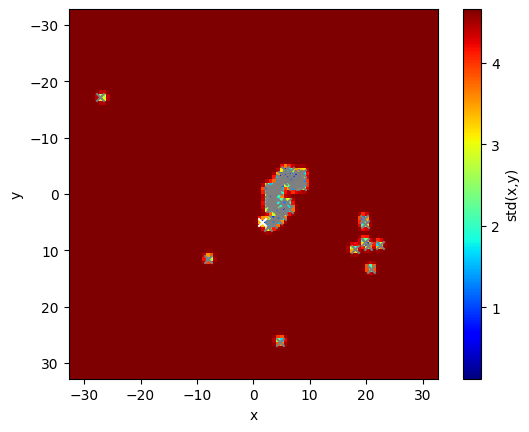

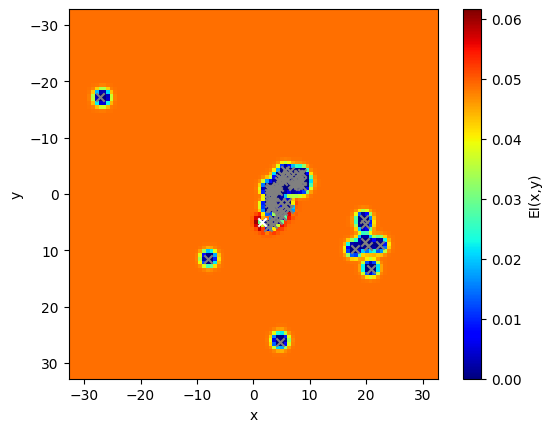

Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [0.81454576 5.55545879]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [6.15543577 3.72503819]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [4.89542393 5.67636578]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [0.45028284 4.24940738]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [1.48117832 3.91261278]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [0.89522139 3.16295349]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [-0.10903826  3.15290957]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [0.35670291 2.17338889]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [-0.75094744  2.11411439]
Best value of  2.6300694

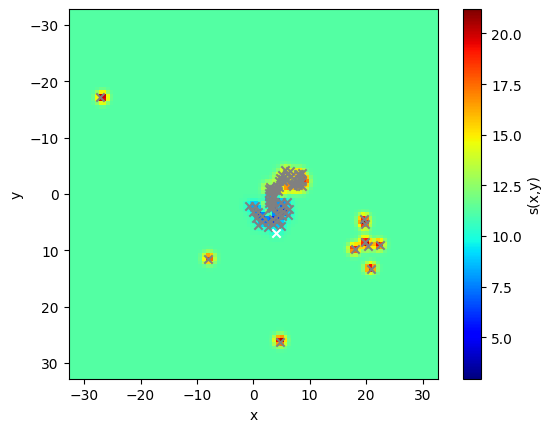

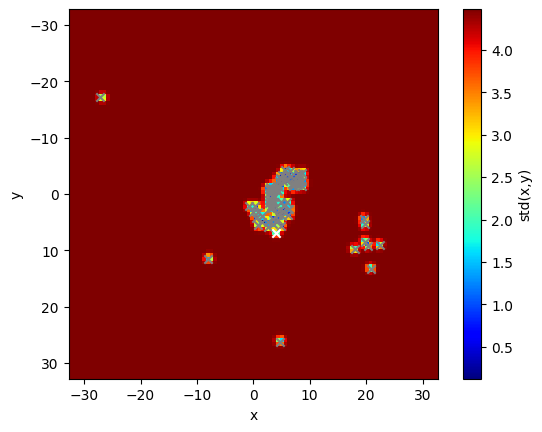

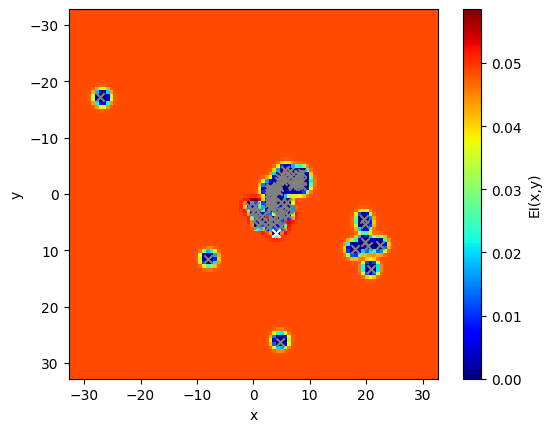

Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [-0.17176982  1.15532235]
Best value of  2.630069435615152  at  [3.17399574 2.16073772]
Last sample point at  [2.55310247 4.17536288]
Best value of  2.5892838282730932  at  [3.14391598 2.20759751]
Last sample point at  [3.14391598 2.20759751]
Best value of  1.0936882834024684  at  [3.30480742 3.10179916]
Last sample point at  [3.30480742 3.10179916]
Best value of  1.0936882834024684  at  [3.30480742 3.10179916]
Last sample point at  [3.63701396 3.19249671]
Best value of  1.0936882834024684  at  [3.30480742 3.10179916]
Last sample point at  [3.09536985 3.4703349 ]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [3.07806981 3.14108042]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [2.37345004 3.41589012]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [2.7712388  3.27665364]
Best value of  0

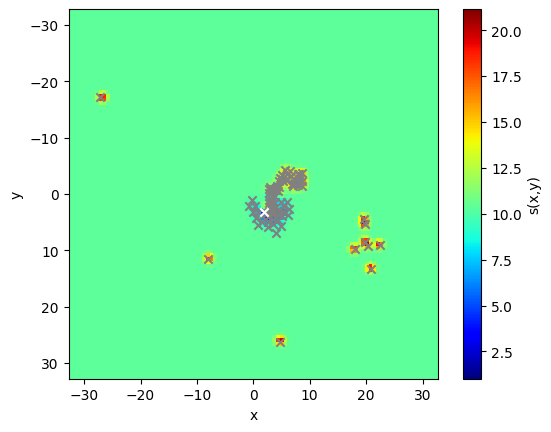

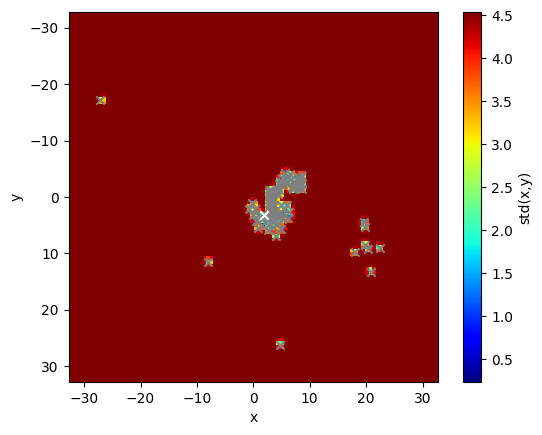

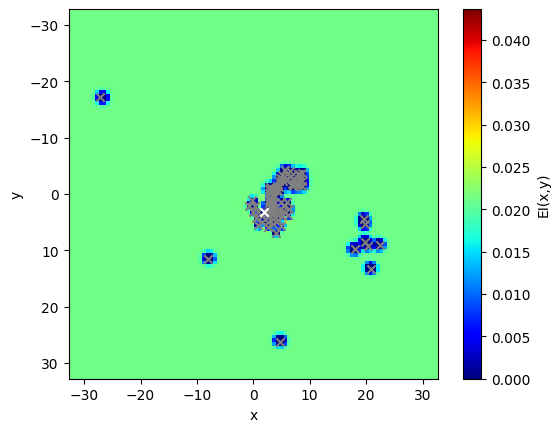

Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [2.08808113 4.22387596]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [2.26295507 3.78112308]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [3.62990641 3.7199864 ]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [1.25233856 2.42727639]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [1.0248213  1.55593459]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [5.25554975 4.76887382]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [6.1952794  5.37435153]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [2.08588937 0.68922517]
Best value of  0.27418570568274747  at  [3.07806981 3.14108042]
Last sample point at  [-0.67178471  4.35512773]
Best val

/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


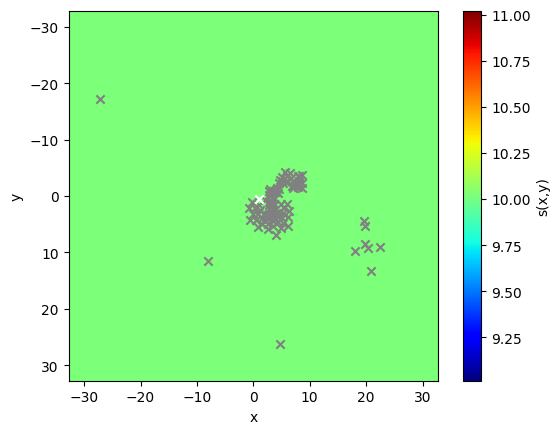

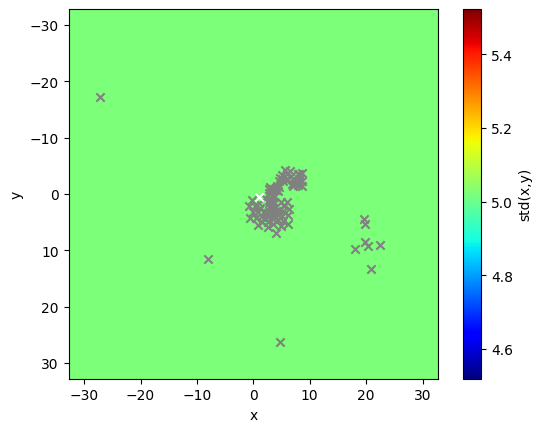

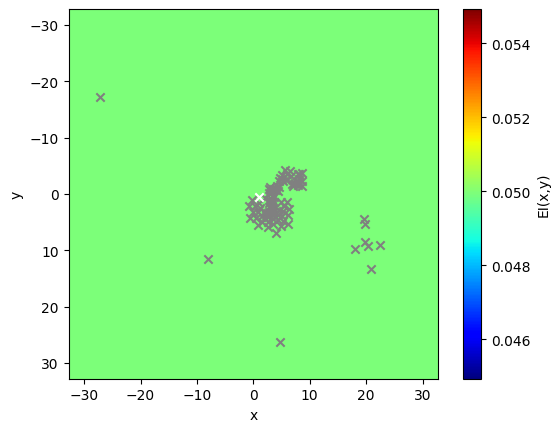

Lowest value of 0.27418570568274747 found at [3.07806981 3.14108042]


In [ ]:
# method = soogo.multistart_msrs
# callback = callback_rbf

# method = soogo.dycors
# callback = callback_rbf

# method = soogo.surrogate_optimization
# callback = callback_rbf_muMeas

method = soogo.cptv
callback = callback_cptv

# method = soogo.cptvl
# callback = callback_cptv

# method = soogo.bayesian_optimization
# callback = callback_gp

# Run optimization
res = method(func, bounds=bounds, maxeval=100, callback=callback, seed=3)

# Print best point found
print(f"Lowest value of {res.fx} found at {res.x}")

Let's run a couple more times the optimization, so we can plot the average convergence curve.

In [28]:
n_trials = 5
list_of_results = [res]
rng = np.random.default_rng(42)
for i in range(1, n_trials):
    res = method(
        func,
        bounds=bounds,
        maxeval=100,
        seed=rng.integers(np.iinfo(np.int32).max).item(),
    )
    print(f"Run #{i}: Lowest value of {res.fx} found at {res.x}")
    list_of_results.append(res)

/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wda

Run #1: Lowest value of 2.6064220572590533 found at [2.21991769 3.12846712]


/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Run #2: Lowest value of 1.6656473427887062 found at [2.99437517 2.9626965 ]


/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Run #3: Lowest value of 0.8717821058883968 found at [3.19010433 3.00634175]


/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/wda

Run #4: Lowest value of 0.2837619824919071 found at [3.09334516 3.09702166]


/Users/wdasilv/repositories/soogo/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


One way to see the results is to plot the average, min and max values obtained for the best solution after each function evaluation.

In [29]:
maxeval = min([len(list_of_results[i].fsample) for i in range(n_trials)])

best_y = np.full((maxeval, n_trials), np.nan)
for i in range(n_trials):  # go through all trials
    Y = list_of_results[i].fsample
    assert Y is not None

    best_y[0, i] = Y[0]
    for j in range(1, maxeval):
        if Y[j] < best_y[j - 1, i]:
            best_y[j, i] = Y[j]
        else:
            best_y[j, i] = best_y[j - 1, i]

mean_y = np.mean(best_y, axis=1)
max_y = np.max(best_y, axis=1)
min_y = np.min(best_y, axis=1)

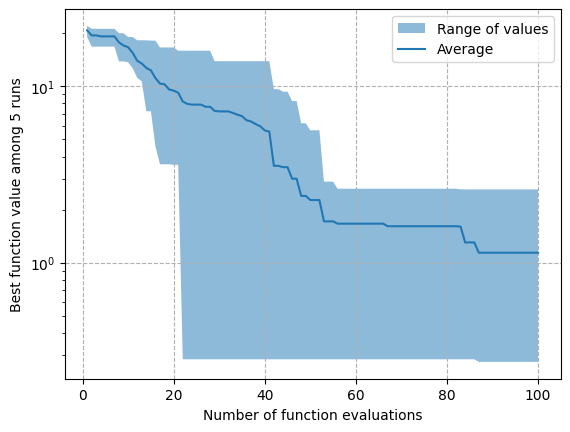

In [30]:
plt.fill_between(
    np.arange(1, maxeval + 1), min_y, max_y, alpha=0.5, label="Range of values"
)
plt.plot(np.arange(1, maxeval + 1), mean_y, label="Average")
plt.yscale("log")
plt.grid(True, linestyle="--")
plt.xlabel("Number of function evaluations")
plt.ylabel(f"Best function value among {n_trials} runs")
plt.legend()
plt.show()